# Math 425 Computation Linear Algebra
## Final Project, Problem 3.
##### *Topics in Matrix Transformation, Least-squares, Linear Modeling and Singular Value Decomposition.

### Group 3

+ Anneke Moeller; Proof reading, code review/validation, math discussion and research
+ Shem Cheng; code review and discussion
+ Rai’d Muhammad; planning
+ Brent Thorne; software, research and reporting

### Problem 3. Classification of Handwritten Digits

##### The objective is to identify handwritten Digits.

In [1]:
# environment setup, try to make it clear which library I'm using for what
import numpy as np  # nice arrays and other stuff
import sympy as sym # symbolic math
from sympy.matrices import Matrix # pretty matrices
from sympy import Eq # pretty equations
from sympy.physics.quantum.dagger import Dagger # we'll want this later...
from math import e, pi, sqrt # Mathy math math
from mpl_toolkits.mplot3d import Axes3D # we like 3d quivers for tutorials
import matplotlib.pyplot as plt # old standby for plotting like a villian
from IPython.display import display, Math, Latex # used to display formatted results in the console
sym.init_printing()  # initialize pretty printing

### Manifest of data files of handwritten digits:
- handwriting training set.txt: 4000 training examples of handwritten digits. Each
training example is a 20 pixel by 20 pixel grayscale image of a digit reshaped into
a 400-dimensional vector. Each pixel is represented by a floating point number that
indicates the grayscale intensity at that location. Thus the set is a 4000 by 400 matrix.
- handwriting training set labels.txt: This data set contains the labels of the corresponding digits in the training set. The digits “1” to “9” are labeled as they are.
However, because MATLAB has no zero index, the digit zero is represented as the
value ten, i.e. “0” is labeled as “10.”
- handwriting test set.txt: 1000 test set of handwritten digits with the same format
as the training set. Thus this set is a 1000 by 400 matrix.
- handwriting test set labels.txt: The labels for the test set.

In [2]:
import csv

def file_ingest(info):
    fdataset, fresults, shape = info
    """
    ingest data and results files, shape not presently used (might add assert if data not in epected shape)
    """
    fname = path+'/'+fdataset
    mylist = []
    with open(fname) as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
                mylist.append(row)
    data = np.array(mylist)
    data = data.astype(float)

    fname = path+'/'+fresults
    mylist = []
    with open(fname) as f:
        reader = csv.reader(f, delimiter='\n')
        for row in reader:
                mylist.append(row)
    results = np.array(mylist)  
    results = results.astype(int)
    results = np.where(results == 10, 0, results) # fix up zero label
    assert len(results) == len(data) # valid training data is labeled

    # generate ordered list of data indices
    indices = [] 
    for n in range(10):
        indices.append(np.where(results==n)[0]) # collect indices for each digit 'result'

    return data, indices, results

In [3]:
def show(r):
    r.shape = (20,20) # our data is an array, reshape it into a 20x20 matrix 
    R = r.T # transpose for humans
    plt.imshow(R, cmap=plt.get_cmap('gray')) # show the humans... more than that, it shows our basis direction
    plt.grid(); plt.gca().set_aspect("equal") 

In [4]:
path = 'data' # this is rather sloppy, we're assigning a global varible to be used above #FIXME
validation_info = ['handwriting_test_set.txt', 'handwriting_test_set_labels.txt', (4000,20,20)]
training_info =  ('handwriting_training_set.txt', 'handwriting_training_set_labels.txt', (1000,20,20))

In [5]:
data, indices, results = file_ingest(training_info)
vdata, vindices, vresults = file_ingest(validation_info) # Error ratio: 0.043 (k=20)
#vdata, vindices, vresults = file_ingest(training_info)  # Error ratio: 0.02475 (k=20)

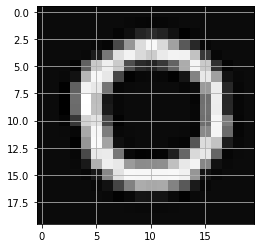

In [6]:
# show a sample of the data
data.shape,
show(data[399])

### A. Construct an algorithm for classification of handwritten digits.

In [7]:
# find singular values for the 400 samples of each character 
SVD = []  # this varible could use a more descriptive name, this is a list of all decomposites
for n in range(10):
    A = (data[indices[n]]).transpose()  # transpose the 400x400 matrix so we can easily see, Av=UW (where W is s)
    u,s,vh = np.linalg.svd(A, full_matrices=False)
    SVD.append([u,s,vh]) # only use the singular vaules
#print(SVD[0][1]) # show a test sigma

####  Do the classification using 5, 10, 15 and 20 singular vectors as a basis.

In [8]:
# function to input K (rank) and outputs percent-error and list of misclassified indexes
def correlate(k):
    misclassified = []
    It = np.zeros((400,400))
    for i in range(k):
        It[i,i]=1

    # now apply this to our validation set
    columnCorrelation = [] 
    for i in range(10):
        U = SVD[i][0] @ It  # truncate Left Vector
    #    print(U.shape)
        columnCorrelation.append(U @ U.transpose())  # See Example 7.4.8 in Lay text.
    # * Note that for this truncated U, U.T*U = I, however U*U.T ≠ I
    # * See also: Lay 7.1 Spectral Decomposition
    # * We ought to be able to form an other basis using V but it hurts my head to think about it...

    # now test our validation set
    error_count=0
    testSize = len(vdata)
    for i in range(testSize): 
        y = (vdata[i]).transpose()
        r = vresults[i] #known value
        dict = {}
        for ii in range(10):
            y_hat = columnCorrelation[ii] @ y # our projection of y onto ColA (U*U.T)
            z = (y - y_hat)
            dict[ii] =  z.dot(z)
        sorted_dict = sorted(dict.items(), key= lambda x:x[1], reverse=False)
        prediction = sorted_dict[0][0] #predicted value
        if (prediction != r): 
            error_count += 1
            misclassified.append([i, list(r)[0], prediction]) # [ index, expected, predicted ], really poor data abstraction
    return(error_count/testSize*100, misclassified)   

 i.   Give a table of graph of the percentage of correctly classified digits as a function of the number of basis vectors.

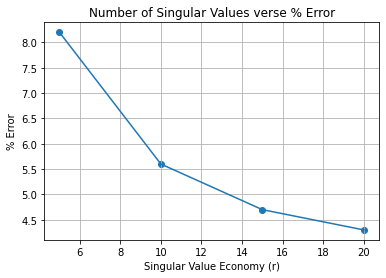

In [9]:
# truncate U 
K = [5,10,15,20]
percent_error = []
for k in K:
    perr, misclassified = correlate(k)
    percent_error.append(perr)

K, percent_error
plt.scatter(K,percent_error)
plt.plot(K,percent_error)
plt.title('Number of Singular Values verse % Error')
plt.ylabel('% Error')
plt.xlabel('Singular Value Economy (r)')
plt.grid()

 ii.  Check is all digits are equally easy or difficult to classify.  Also look at some of the difficult ones, and see that in may cases they are very badly written.


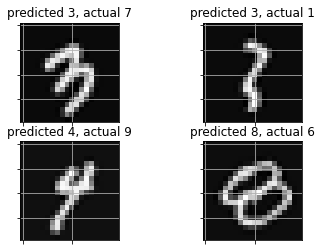

Above we selected samples showing poor handwriting or initial training mistakes.


In [10]:
interestingCases = [37,110,115,156]
ii = [1,2,6,8]
f, axes = plt.subplots(2, 2)
axes = axes.flatten() 
#for i in range(len(misclassified)):
xx = 0
for i in ii:
    plt.sca(axes[xx]); xx+=1 # ugly code, pretty pictures
    plt.tick_params(axis='x',which='both', labelbottom=False)
    plt.tick_params(axis='y',which='both', labelleft=False)
    plt.title(f'predicted {misclassified[i][1]}, actual {misclassified[i][2]}')
    show(vdata[misclassified[i][0]])
plt.show()
  
print('Above we selected samples showing poor handwriting or initial training mistakes.')

 
 iii. Check the singular values of the different classes.  Is there evidence to support using different number of basis for different digits?

The following plot explores setting a zero threshold for Sigma values and provides a motivation for further studies into truncation, alignment, optimal hard threshold and the condition-number metric.


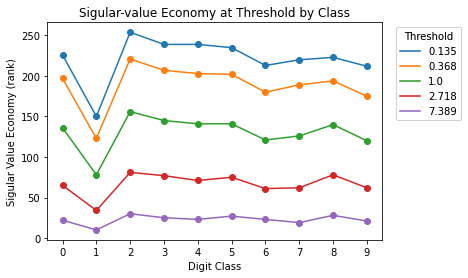

Note how some classes need fewer singular values(i.e. '1'), while others such as need a full rank (i.e. '2').

Indeed, some digits are more economical than others, however decreasing the cutoff threshold doesn't improve the percent-error as seen in Section(i) above.


<IPython.core.display.Latex object>

See: Eckard-Young Theorem [1936]
See also: https://en.wikipedia.org/wiki/Low-rank_approximation


In [11]:
print("The following plot explores setting a zero threshold for Sigma values \
and provides a motivation for further studies into truncation, alignment, \
optimal hard threshold and the condition-number metric.")
thresRange = e**np.linspace(-2,2, num=5) # use a log scale to set out threshold
plotData = []
for sigmaThreshold in thresRange:
    economyLen = []
    for v in SVD: 
        s = list(v[1])
        maxSigma = max(s)
        ss = [i for i in s if i > sigmaThreshold]
        economyLen.append(len(ss))
    plotData.append([range(10), economyLen, f'{round(sigmaThreshold,3)}' ])
    
fig, ax = plt.subplots()
plt.xticks(range(10))
ld =[]
for i in range(len(plotData)):
    lines = ax.plot(plotData[i][0],plotData[i][1]) # poor data abstraction, but it not like we're getting paid to do this 
    ld.append(plotData[i][2])
legend1 = ax.legend(ld, bbox_to_anchor=(1.25, 1),loc="upper right", title="Threshold")
ax.add_artist(legend1)    
    
for i in range(len(plotData)):
    scatter = ax.scatter(plotData[i][0],plotData[i][1])
plt.title('Simgular-Value Economy at Threshold by Class')
plt.xlabel('Digit Class')
plt.ylabel('Singular Value Economy (rank)')
plt.show()
    
#print(f'The non-zero sigma at threshold (min, max): ({min(economyLen)}, {max(economyLen)})\n')
print("Note how some classes need fewer singular values(i.e. '1'), \
while others need a full rank (i.e. '2').\n")
print("Indeed, some digits are more economical than others, \
however decreasing the cutoff threshold doesn't improve the percent-error \
as seen in Section(i) above.")
display(Latex('A better metric of this economy might have been to compare \
$\\sigma_i$ to $\\frac{\\sigma_1}{\\sigma_n}$ (condition number) \
and should be an area for further studies and research.'))

print("See: Eckard-Young Theorem [1936]")
print("See also: https://en.wikipedia.org/wiki/Low-rank_approximation")

### B. Implement the following two-stage algorithm:
In the first stage compare the unknown digit only to the first singular vector in each class.  If for one class/digit the residual is significantly smaller than the other, classify as that digit.  Otherwise perform the algorithm above.  

In [12]:
# function to input K (rank) and outputs percent-error and list of misclassifed indexes
It_K1 = np.zeros((400,400))
It_K1[0,0]=1

It_K20 = np.zeros((400,400))
for i in range(k):
    It_K20[i,i]=1

columnCorrelationK1 = [] 
columnCorrelationK20 = [] 
for i in range(10):
    U_K1 = SVD[i][0] @ It_K1  # truncate Left Vector
    U_K20 = SVD[i][0] @ It_K20  # truncate Left Vector
    columnCorrelationK1.append(U_K1 @ U_K1.transpose()) 
    columnCorrelationK20.append(U_K20 @ U_K20.transpose()) 
        
meanLogthres = [0.01, 0.1, 0.2, 0.4, 0.8]        
perrorList = []
p2ndApply = []
for thres in meanLogthres:
    # apply first level
    secondTierCount = 0
    error_count=0
    testSize = len(vdata)
    misclassified=[]
    for i in range(testSize): 
        y = (vdata[i]).transpose() # again really bad data abstraction
        r = vresults[i] #known value
        dict = {}
        for ii in range(10):
            y_hat = columnCorrelationK1[ii] @ y # our projection of y onto ColA (U*U.T)
            z = (y - y_hat)
            dict[ii] =  np.log(np.sqrt(z.dot(z)))  # we'll use log scale now
        sorted_dict = sorted(dict.items(), key= lambda x:x[1], reverse=False)
        prediction = sorted_dict[0][0] #predicted value
        #delta = sorted_dict[1][1]-sorted_dict[0][1]
        delta = abs(sorted_dict[0][1] - (sum(dict.values()) / len(dict)))

        # apply second level
        if delta< thres: #0.4: #0.2: # recall we're using a log scale
            secondTierCount += 1
            dict = {}
            for ii in range(10):
                y_hat = columnCorrelationK20[ii] @ y # our projection of y onto ColA (U*U.T)
                z = (y - y_hat)
                dict[ii] =  np.log(np.sqrt(z.dot(z)))  # we'll use log scale now
            sorted_dict = sorted(dict.items(), key= lambda x:x[1], reverse=False)
            prediction = sorted_dict[0][0] #predicted value

        if (prediction != r): 
    #        print(f'{sorted_dict}\n')
    #        print('^misclassification\n')
            error_count += 1
            misclassified.append([i, list(r)[0], prediction]) # [ index, expected, predicted ], really poor data abstraction
    perrorList.append(error_count/testSize*100)
    p2ndApply.append(secondTierCount/testSize*100)
#print(f'Percent Error: {round(error_count/testSize*100,1)}') 
#print(f'Percentage of Second Stage Applications: {round(secondTierCount/testSize*100,1)}')

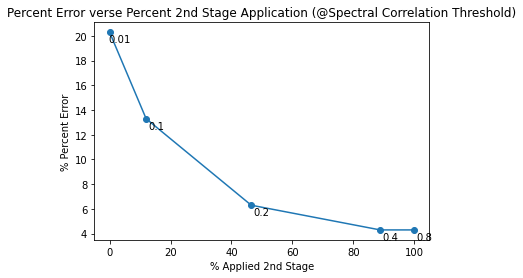

<IPython.core.display.Latex object>

In [13]:
# Plot Percent Error at various Spectral Correlation Thresholds
plt.plot(p2ndApply, perrorList)

for i in range(len(meanLogthres)):
    plt.annotate(meanLogthres[round(i)],\
                 (p2ndApply[i], perrorList[i]), 
                 textcoords="offset points",
                 xytext=(10,-10),
                 ha='center') 

plt.scatter(p2ndApply, perrorList)
plt.title('Percent Error verse Percent 2nd Stage Application (@Spectral Correlation Threshold)')
plt.xlabel('% Applied 2nd Stage')
plt.ylabel('% Percent Error')
plt.show()
display(Latex("The above graph shows the measured \
Percent-Error verse Percentage-of-2nd-Stage-Applications at \
a range of abstract thresholds.  We call this threshold a \
'Spectral Correlation Threshold' as it is a log-measure \
of the perpendicular component of the validation sample to the Left Singular Vector ($U$)."))

#### Is it possible to get as good a result for this version?
A mean-log-distance comparison was performed with the sorted log-least-distance.  We were able to achieve a similar minimal percent error.

#### How frequently is the second stage necessary?
To achieve the same 4.3% error as the original k=20 implementation the 2nd stage was applied 88.8% of the time.  Relaxing mean-log-distance threshold increased the error-rate to 6.3% but only required applying the Second Stage 46.5% of the time.

This result shows that a multi-stage algorithm could be used to reduce classification time and computational complexity.  The current implementation does not take into consideration any optimizations and is intended for academic purposes.  An optimized implementation might take advantage of iterative linear programming to carry out successive operations until a desired confidence threshold is meet.  This is a potential area of further study.

###  Appendix 1. SVD References

https://www.tutorialexample.com/calculate-singular-value-decomposition-svd-using-numpy-numpy-example/

https://cmdlinetips.com/2019/05/singular-value-decomposition-svd-in-python/

### Appendix 2. Animate Samples

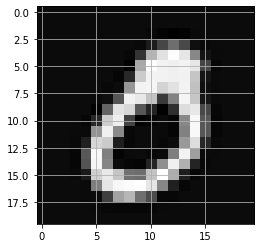

In [14]:
# animate a few samples  
from matplotlib.animation import FuncAnimation, PillowWriter
from os.path import exists
filename = "handwritting.gif"
    
fig, ax = plt.subplots()

def init():
    plt.grid()
    plt.gca().set_aspect("equal") 

def update(i):
    r = data[indices[0][i]]  # 't' is our random training set from above
    show(r)
    
ani = FuncAnimation(fig, update, range(10), init_func=init)  
writer = PillowWriter(fps=25)  
ani.save(filename, writer=writer)
plt.show()

### Appendix 3. Show Animated Samples
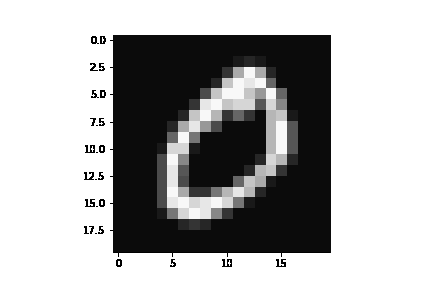